In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


In [234]:
import os
import pandas as pd
import numpy as np

from tqdm import tqdm

In [4]:
matrix_dir = "data/MIT-Matrix-Data/"

In [23]:
def read_ble_from_file(fp):
    return [ float(line.split(',')[3])
            for line in open(fp).read().split('\n')
            if 'Bluetooth' in line ]

In [244]:
def apply_fn_to_matrix_data_files(matrix_dir, fn, as_df=False):
    _apply_out = []
    folders = list(os.walk(matrix_dir))
    for dirpath, dirnames, filenames in tqdm(folders, total=len(folders)):
        for filename in [f for f in filenames if f.endswith(".txt")]:
            fp = os.path.join(dirpath, filename)
            _apply_out.append(fn(fp))
    if as_df:
        return pd.DataFrame(_apply_out)
    return _apply_out

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

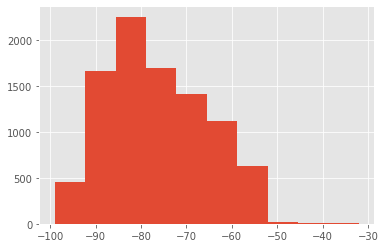

In [14]:
ble_readings = [ float(line.split(',')[3]) for line in ble ]
plt.hist(ble_readings);

In [269]:
def to_dt(t):
    # ValueError: time data '2020-05-19T17:31:41.794Z'
    try:
        return datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%fZ')

def t_diff(t1, t2):
    return abs((to_dt(t2) - to_dt(t1)).total_seconds())

def read_bluetooth_dataframe(fp):
    events, timestamps = [], []
    for line in open(fp).read().split('\n'):
        if 'Bluetooth' in line:
            items = line.split(',')
            _ble = items[3]
            _timestamp = items[0]
            if len(events) > 0:
                _t_diff = t_diff(_timestamp, timestamps[-1])
                t = events[-1]['Time'] + _t_diff
            else:
                t, _t_diff = 0., 0.
            events.append({
                "Time" : t,
                "Bluetooth" : float(_ble),
                "TimeDiff" : _t_diff
            })
            timestamps.append(_timestamp)
    return pd.DataFrame(events)

def read_bluetooth_chirps(fp):
    chirp, chirps, timestamps = [], [], []
    for line in open(fp).read().split('\n'):
        if 'Bluetooth' in line:
            
            items = line.split(',')
            _ble = items[3]
            _timestamp = items[0]
            if len(chirp) == 0 and len(chirps) == 0:
                t, _t_diff = 0., 0.
            else:
                
                _t_diff = t_diff(_timestamp, timestamps[-1])
                t = chirp[-1]['Time'] + _t_diff
            if _t_diff > 0.2:
                chirps.append(chirp)
                chirp = []
            chirp.append({
                "Time" : t,
                "Bluetooth" : _ble,
                "TimeDiff" : _t_diff
            })
            timestamps.append(_timestamp)
    chirps.append(chirp)
    return [ pd.DataFrame(chirp) for chirp in chirps ]

In [106]:
chirps = read_bluetooth_chirps(fp)

In [107]:
len(chirps)

8

In [110]:
chirps[0]

Time Bluetooth  TimeDiff
0     0.000       -71     0.000
1     0.032       -69     0.032
2     0.033       -69     0.001
3     0.034       -89     0.001
4     0.036       -90     0.002
...     ...       ...       ...
1110  9.943       -96     0.024
1111  9.951       -94     0.008
1112  9.952       -93     0.001
1113  9.980       -87     0.028
1114  9.981       -87     0.001

[1115 rows x 3 columns]

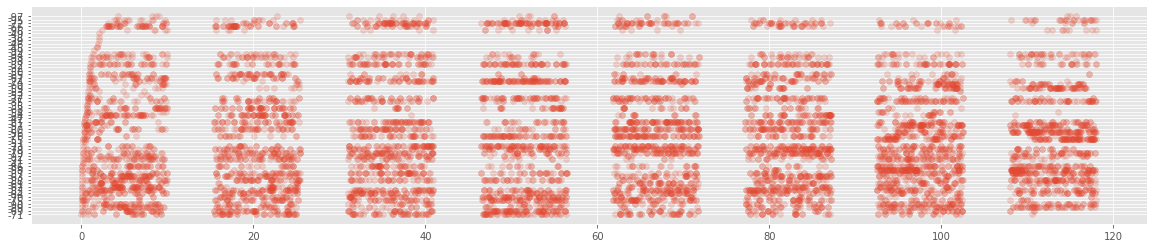

In [85]:
plt.figure(figsize=(20, 4))
plt.scatter(df.Time, df.Bluetooth, alpha=0.2);

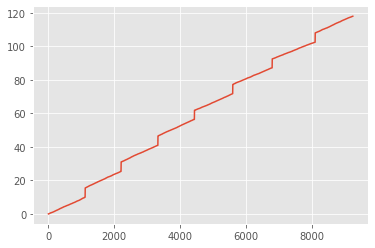

In [86]:
plt.plot(df.Time)

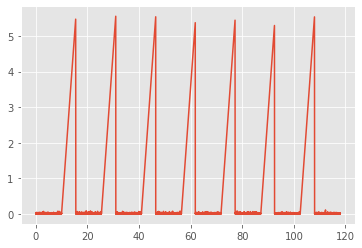

In [91]:
plt.plot(df.Time, df.TimeDiff)

## What are the devices present?

In [135]:
fp = "data/MIT-Matrix-Data/FrontPantsPocketUP_ShirtPocketDOWN/FrontPantsPocketUP_ShirtPocketDOWN_10ft_log_2020-05-12_15.15.56.858.txt"

In [164]:
open(fp).read().split('\n')[:10]

['2020-05-12 15:15:56.867,scenario,structured_Test Protocol Full ',
 '2020-05-12 15:15:56.866,environment,medium room,center open',
 '2020-05-12 15:15:56.867,subject,front pants pocket,standing,unknown',
 '2020-05-12 15:15:56.874,session_id,pact_20200512150150295',
 '2020-05-12 15:15:56.872,user_id, ',
 '2020-05-12 15:15:56.873,beacon, ,iPhone XR',
 '2020-05-12 15:15:56.873,receiver, iPhone XR,James’s iPhone',
 '2020-05-12 15:15:56.875,beacon_subject,shirt pocket,sitting',
 '2020-05-12 15:15:56.876,Range,10',
 '2020-05-12 15:15:56.877,Angle,0']

In [143]:
open(fp).read().split('\n')[:10][6].split(',')[-2].strip()

['2020-05-12 15:15:56.873', 'receiver', ' iPhone XR', 'James’s iPhone']

In [288]:
def get_headers(fp):
    lines = open(fp).read().split('\n')
    devices = {}
    for line in lines[:10]:
        if 'beacon' in line and 'beacon_subject' not in line:
            a, b = line.split(',')[-2].strip(), line.split(',')[-1].strip()
            devices['TX'] = b if a == '' else a
            devices['TX'] = devices['TX']  #+ ' | ' + line
        if 'receiver' in line:
            a, b = line.split(',')[-2].strip(), line.split(',')[-1].strip()
            devices['RX'] = b if a == '' else a
            devices['RX'] = devices['RX']  #+ ' | ' + line
        if 'environment' in line:
            _, _, e1, e2 = line.split(',')
            devices['Environment_1'] = e1.strip()
            devices['Environment_2'] = e2.strip()
        if 'Range' in line:
            devices['Range'] = float(line.split(',')[-1])
        if 'Angle' in line:
            devices['Angle'] = float(line.split(',')[-1])
    devices['Bluetooth'] = read_ble_from_file(fp)
    return devices

In [290]:
metadata = apply_fn_to_matrix_data_files(matrix_dir, get_headers, as_df=True)
metadata

100%|██████████| 14/14 [00:00<00:00, 14.92it/s]


Environment_1 Environment_2         TX             RX  Range  Angle  \
0      large room   center open  iPhone XS       iPhone 8    5.0    0.0   
1      large room   center open  iPhone XS       iPhone 8    4.0    0.0   
2      large room   center open  iPhone XS       iPhone 8   10.0    0.0   
3      large room   center open  iPhone XS       iPhone 8   15.0    0.0   
4      large room   center open  iPhone XS       iPhone 8    8.0    0.0   
..            ...           ...        ...            ...    ...    ...   
102    large room   center open  iPhone XR  iPhone 11 Pro    8.0    0.0   
103    large room   center open  iPhone XR  iPhone 11 Pro   12.0    0.0   
104    large room   center open  iPhone XR  iPhone 11 Pro    5.0    0.0   
105    large room   center open  iPhone XR  iPhone 11 Pro   15.0    0.0   
106    large room   center open  iPhone XR  iPhone 11 Pro    6.0    0.0   

                                             Bluetooth  
0    [-84.0, -84.0, -71.0, -61.0, -83.0, -82.0, -82...  
1    [-59.0, -75.0, -75.0, -55.0, -55.0, -92.0, -75...  
2    [-82.0, -77.0, -78.0, -85.0, -85.0, -72.0, -75...  
3    [-71.0, -74.0, -69.0, -69.0, -64.0, -64.0, -76...  
4    [-79.0, -79.0, -73.0, -84.0, -74.0, -56.0, -56...  
..                                                 ...  
102  [-55.0, -55.0, -79.0, -75.0, -73.0, -57.0, -57...  
103  [-76.0, -83.0, -63.0, -63.0, -71.0, -71.0, -91...  
104  [-72.0, -83.0, -54.0, -54.0, -55.0, -55.0, -75...  
105  [-71.0, -71.0, -93.0, -93.0, -68.0, -82.0, -62...  
106  [-67.0, -59.0, -59.0, -84.0, -57.0, -58.0, -74...  

[107 rows x 7 columns]

## Devices

In [184]:
sorted(metadata.TX.fillna('iPhone 6s').unique())

['iPhone 11',
 'iPhone 11 Pro',
 'iPhone 6s',
 'iPhone 8',
 'iPhone XR',
 'iPhone XS']

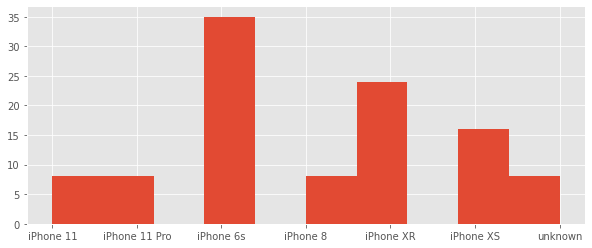

In [197]:
plt.figure(figsize=(10, 4))
metadata.TX.fillna('unknown').sort_values().hist();

In [199]:

sorted(metadata.RX.fillna('unkown').unique())

['iPhone 11 Pro',
 'iPhone 11 Pro Max',
 'iPhone 6s',
 'iPhone 8',
 'iPhone XR',
 'unkown']

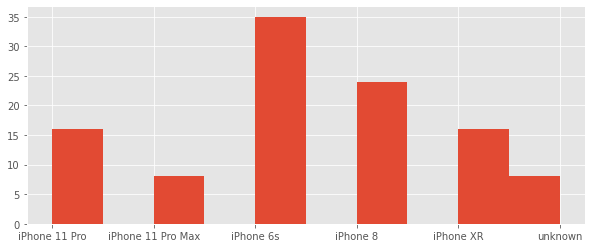

In [200]:
plt.figure(figsize=(10, 4))
metadata.RX.fillna('unknown').sort_values().hist();

## Environments

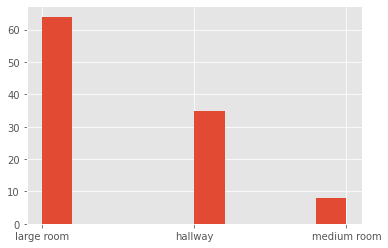

In [202]:
metadata.Environment_1.hist();

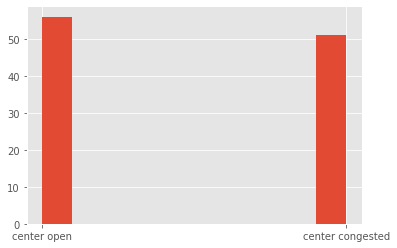

In [203]:
metadata.Environment_2.hist();

## Range

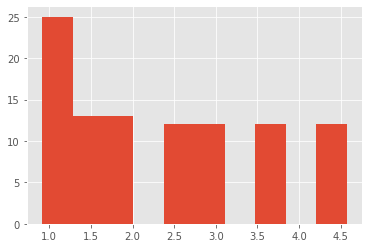

In [206]:
(metadata.Range/3.281).hist();

## Angle

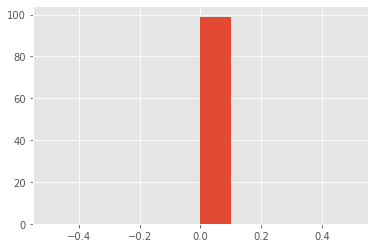

In [209]:
metadata.Angle.hist();

## Plot bluetooth chirps

In [270]:
out = apply_fn_to_matrix_data_files(matrix_dir, read_bluetooth_dataframe)

100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


In [271]:
out[0]

Time  Bluetooth  TimeDiff
0       0.000      -84.0     0.000
1       0.001      -84.0     0.001
2       0.011      -71.0     0.010
3       0.024      -61.0     0.013
4       0.027      -83.0     0.003
...       ...        ...       ...
9289  117.885      -65.0     0.001
9290  117.887     -101.0     0.002
9291  117.896      -96.0     0.009
9292  117.903      -91.0     0.007
9293  117.904      -90.0     0.001

[9294 rows x 3 columns]

In [261]:
import seaborn as sns

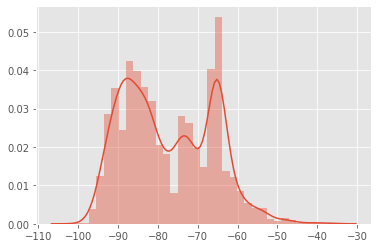

In [272]:
sns.distplot(out[0].Bluetooth.values);

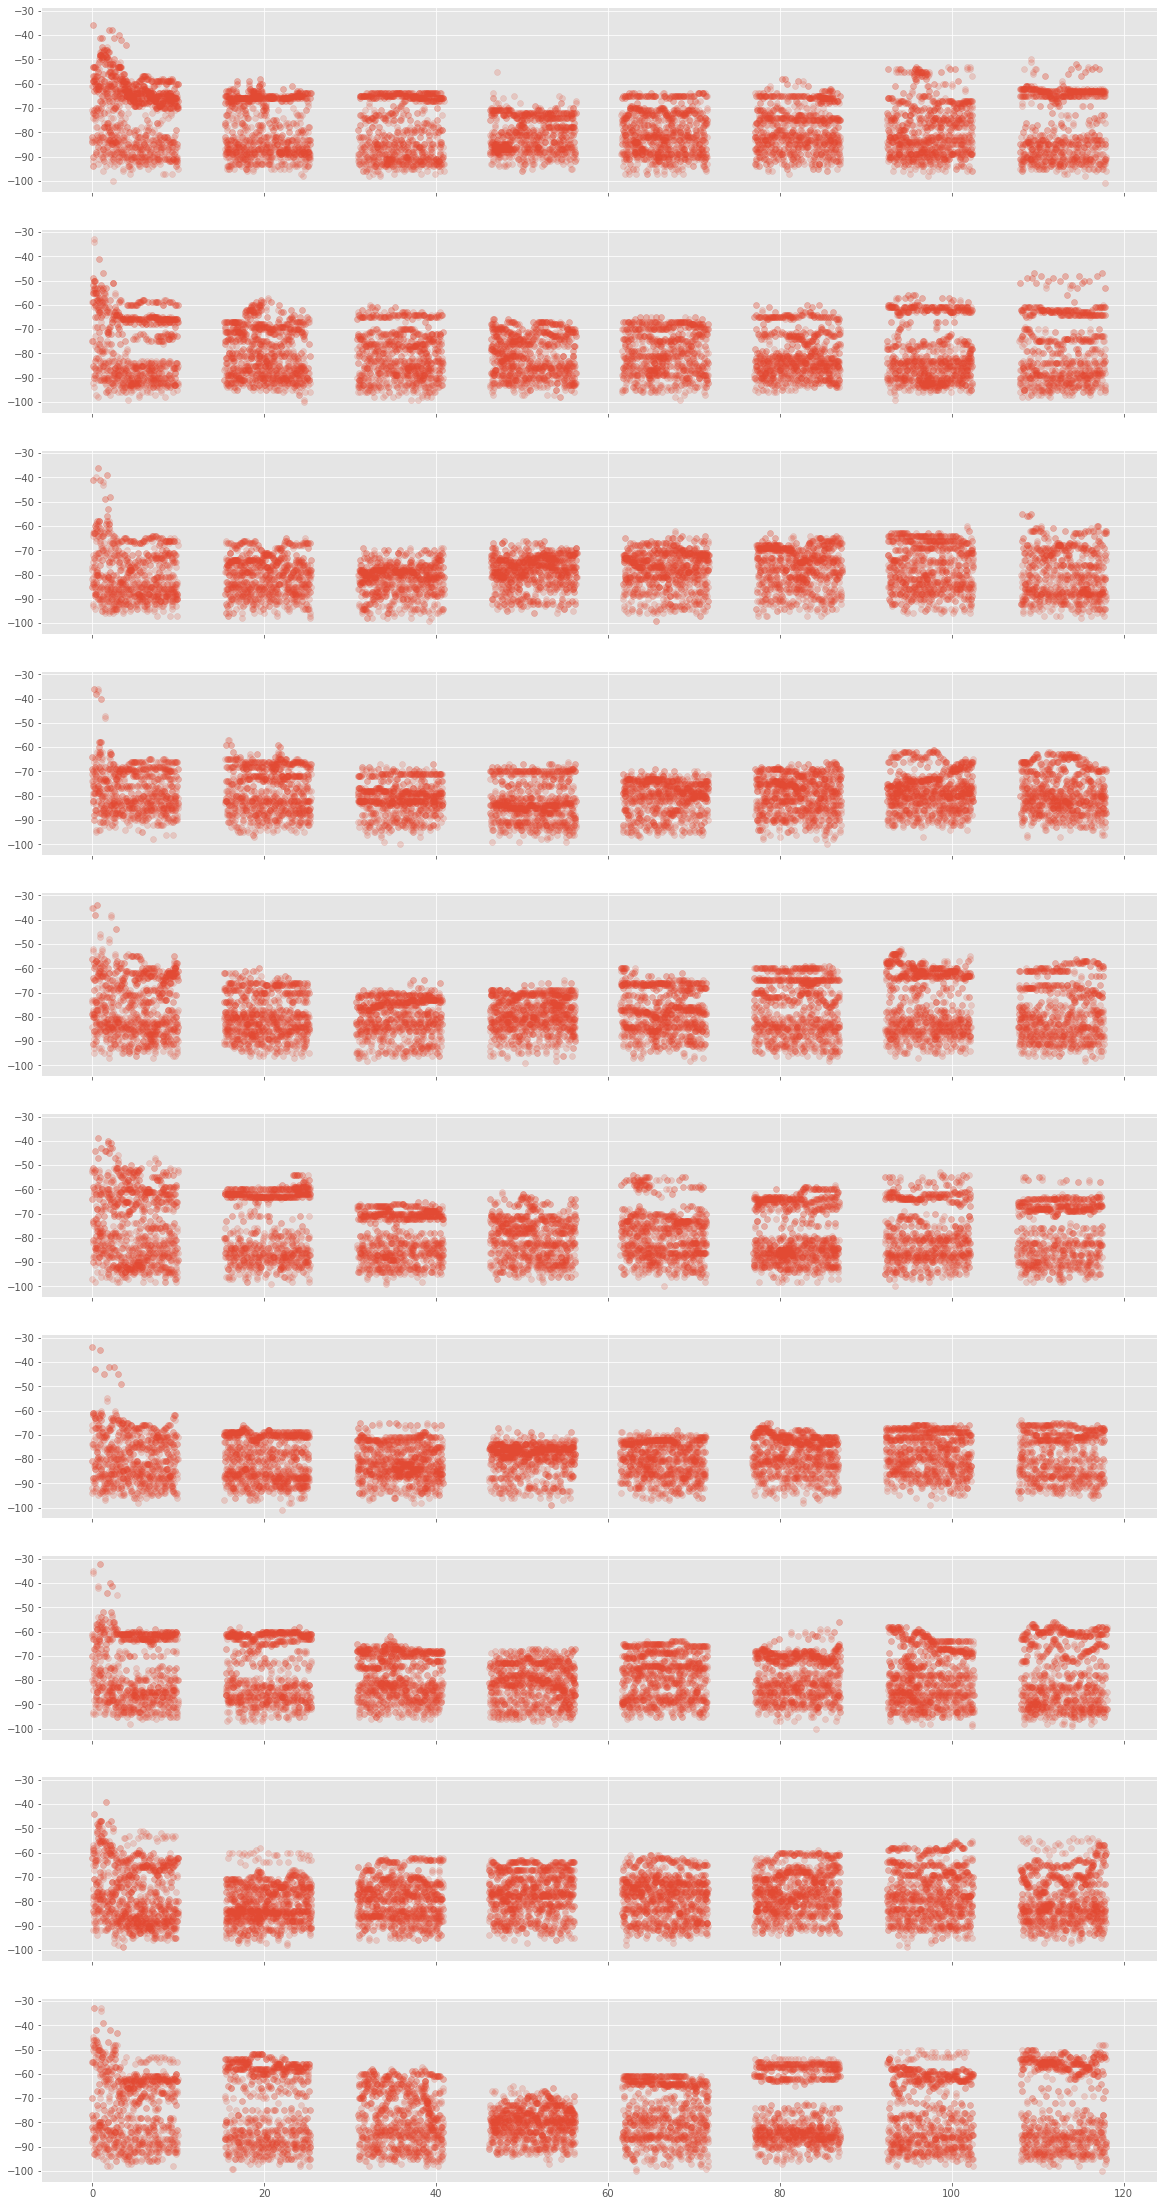

In [276]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(20, 4*10), sharey=True, sharex=True)
axes = axes.flatten()
for ax, df in zip(axes, out[:10]):
    ax.scatter(df.Time, df.Bluetooth, alpha=0.2);
    

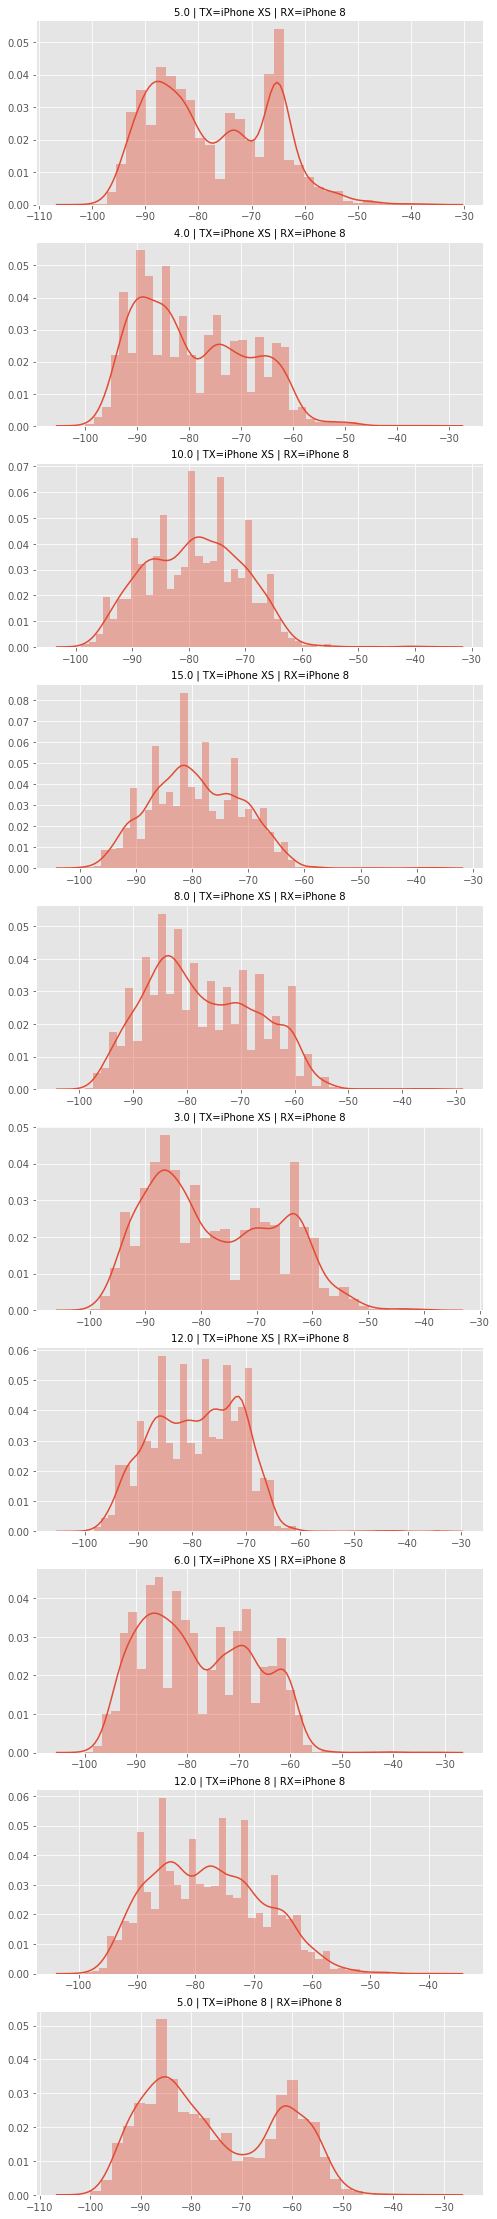

In [287]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(8, 4*10))#, sharey=True, sharex=True)
axes = axes.flatten()
for i, (ax, df) in enumerate(zip(axes, out[:10])):
    sns.distplot(df.Bluetooth, ax=ax);
    ax.set_title(str(metadata.loc[i].Range) + ' | TX=' + metadata.loc[i].TX + ' | RX=' + metadata.loc[i].RX,
                fontsize=10)
    ax.set_xlabel('')

In [303]:
metadata.columns

Index(['Environment_1', 'Environment_2', 'TX', 'RX', 'Range', 'Angle',
       'Bluetooth'],
      dtype='object')

In [311]:
metadata.Range.unique()

array([ 5.,  4., 10., 15.,  8.,  3., 12.,  6., nan])

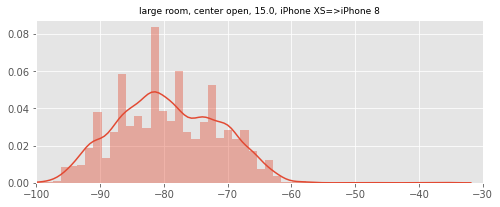

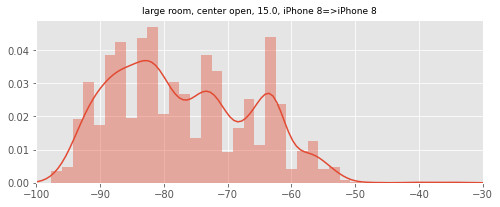

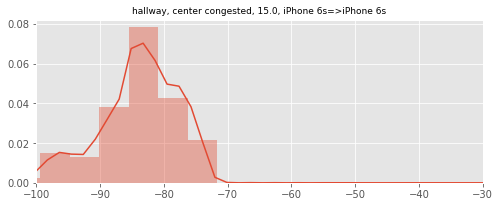

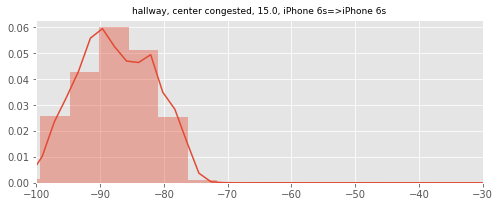

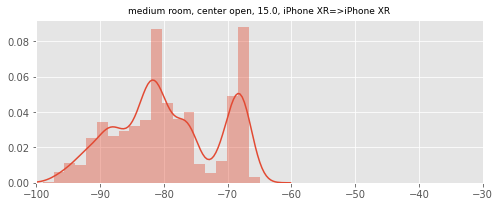

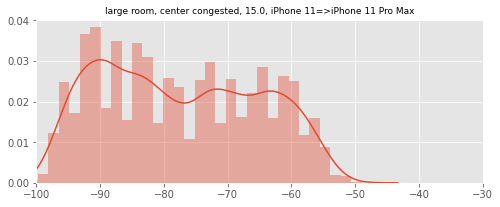

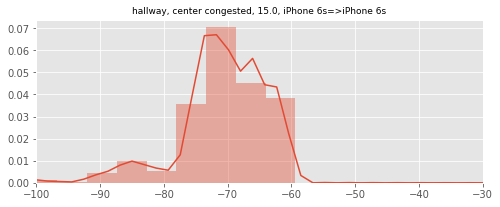

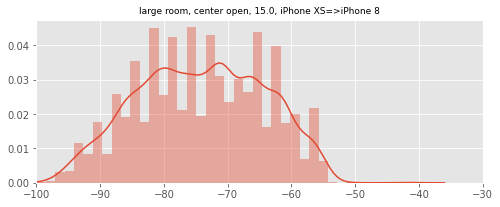

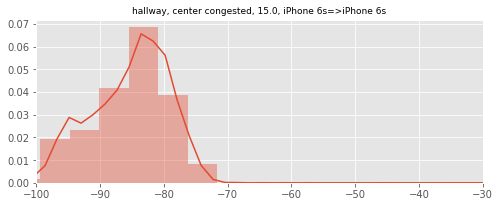

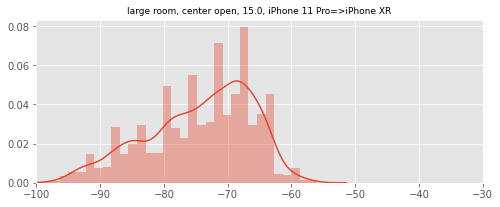

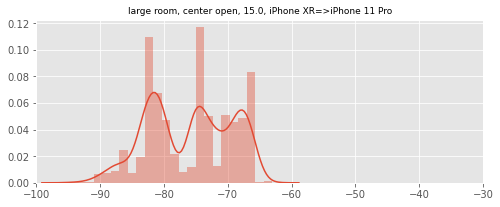

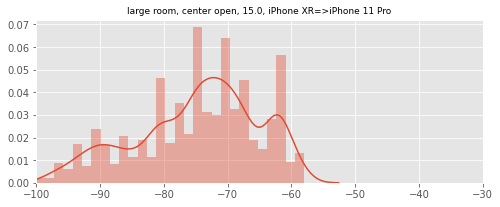

In [313]:
for idx, row in metadata[metadata.Range == 15.].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

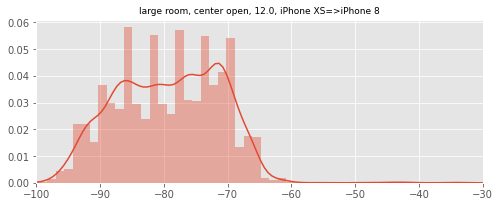

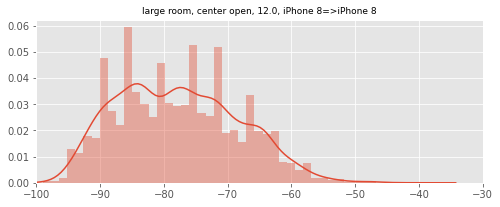

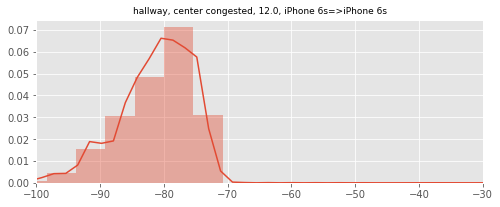

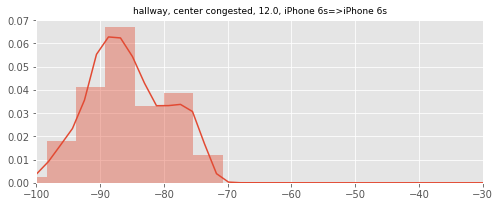

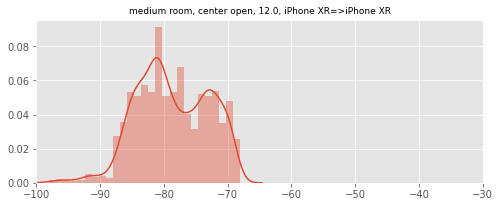

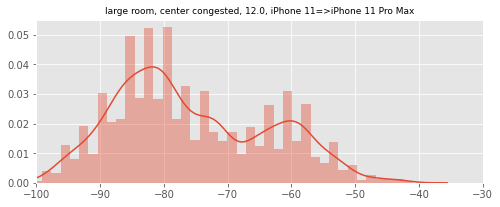

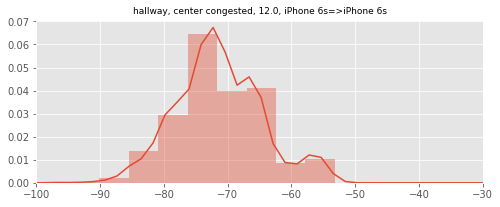

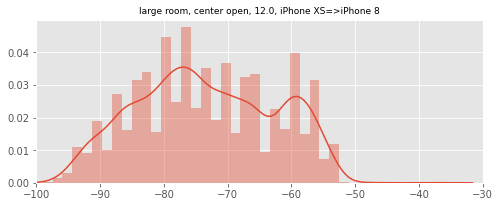

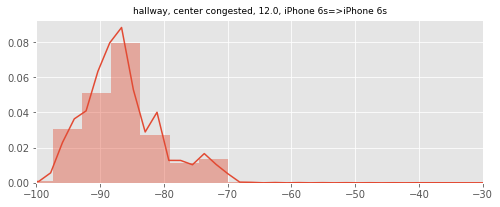

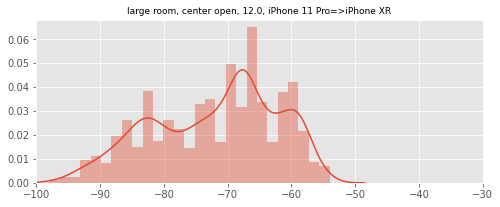

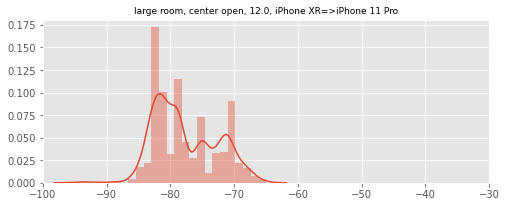

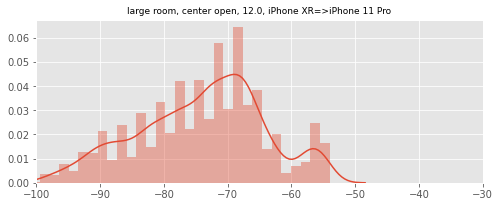

In [314]:
for idx, row in metadata[metadata.Range == 12.].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

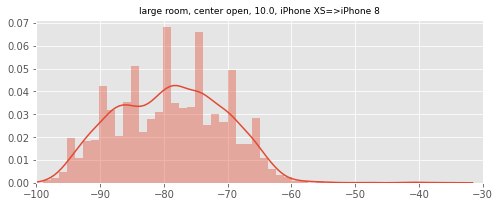

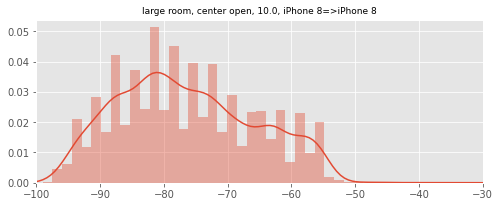

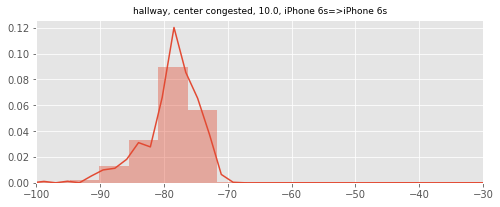

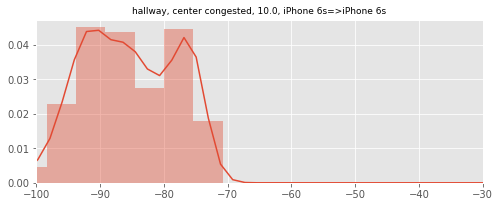

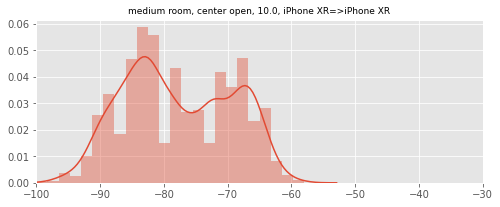

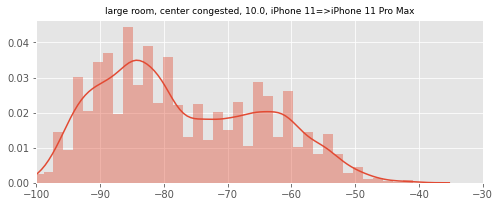

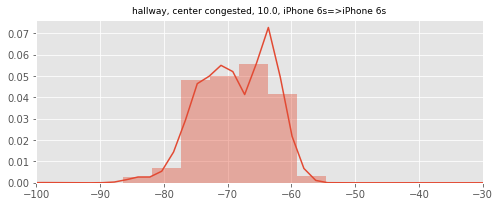

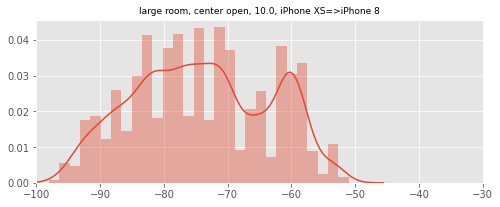

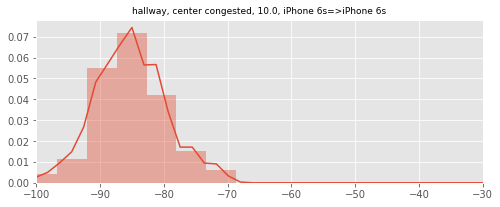

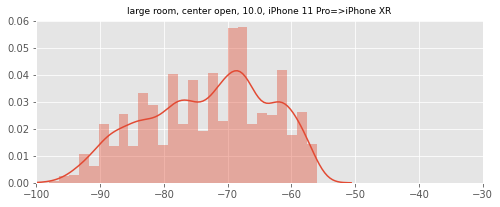

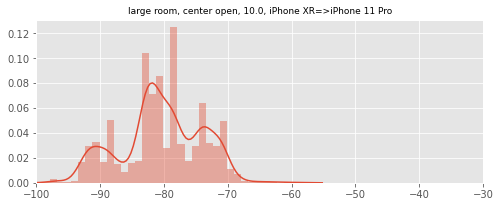

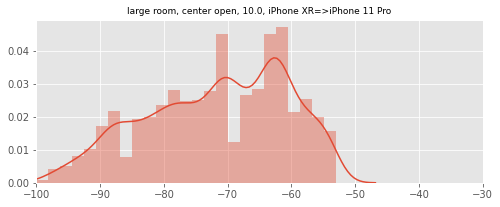

In [315]:
for idx, row in metadata[metadata.Range == 10.].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

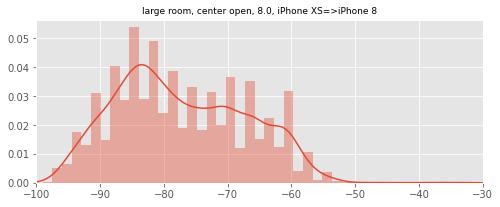

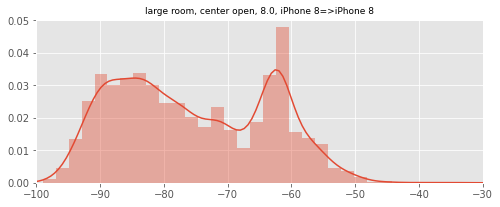

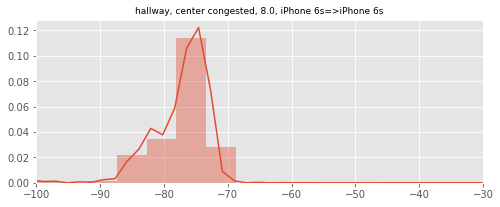

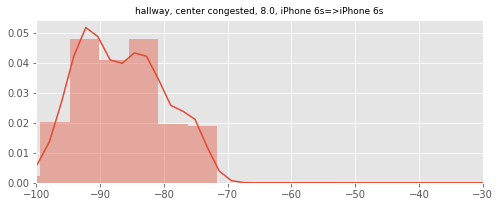

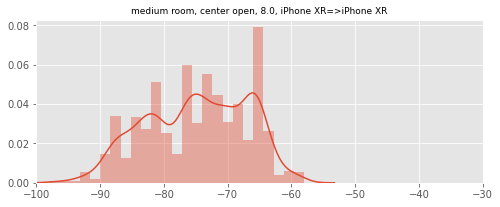

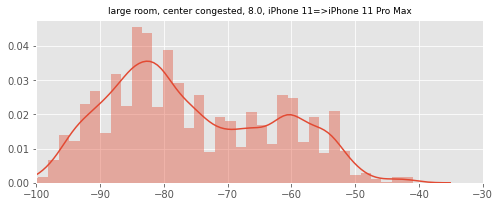

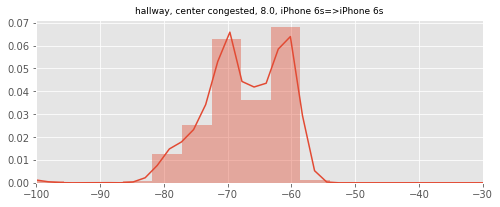

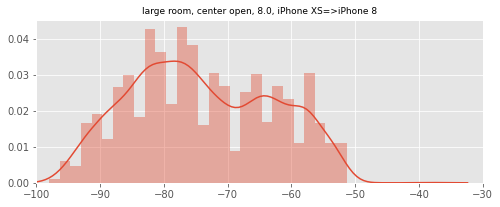

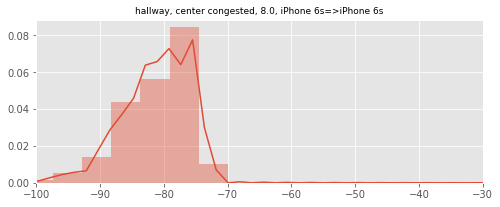

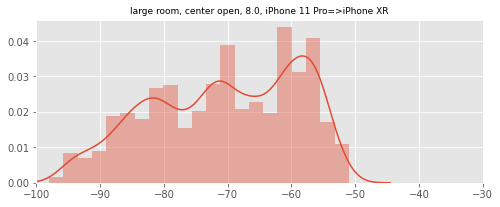

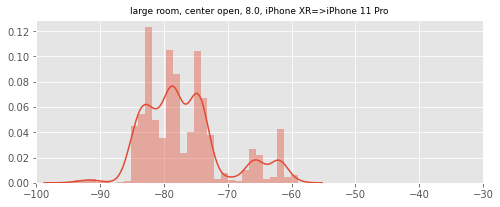

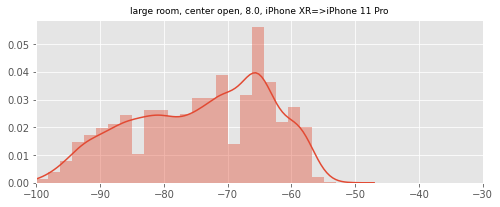

In [316]:
for idx, row in metadata[metadata.Range == 8.].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

In [317]:
metadata.Range.unique()

array([ 5.,  4., 10., 15.,  8.,  3., 12.,  6., nan])

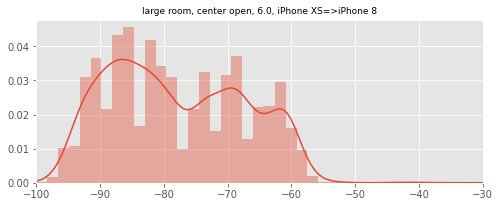

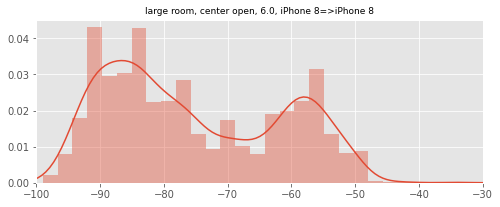

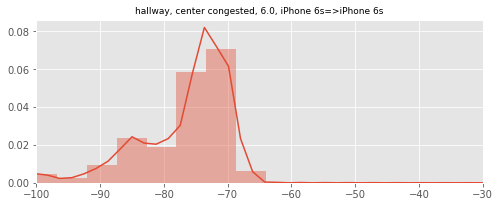

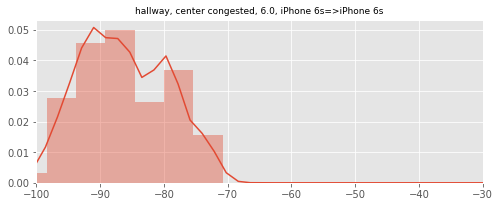

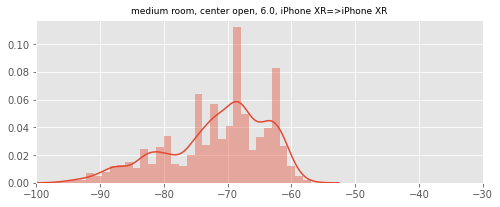

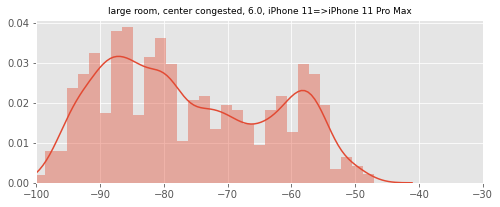

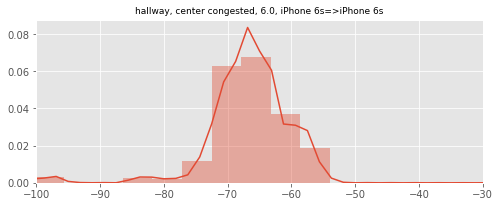

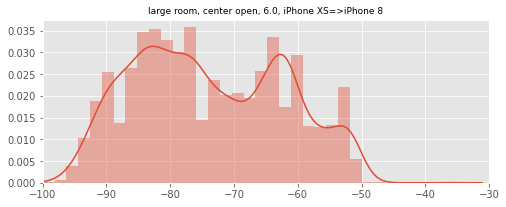

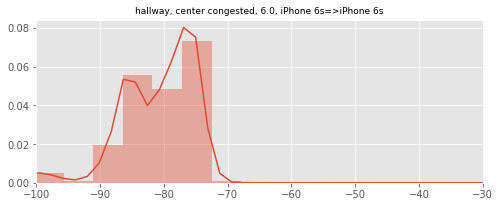

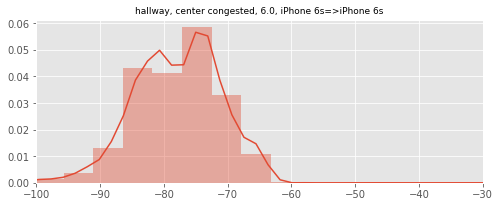

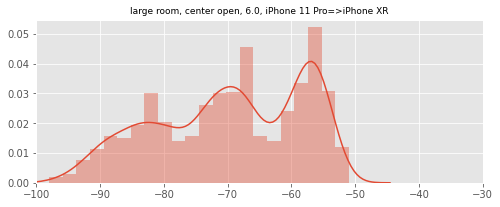

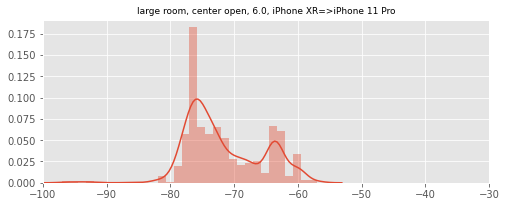

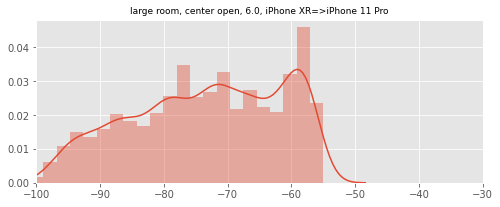

In [318]:
for idx, row in metadata[metadata.Range == 6.].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


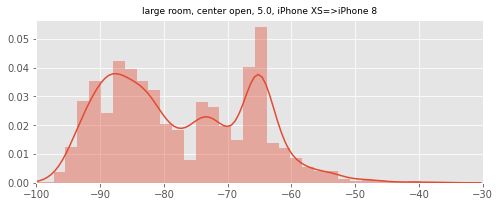

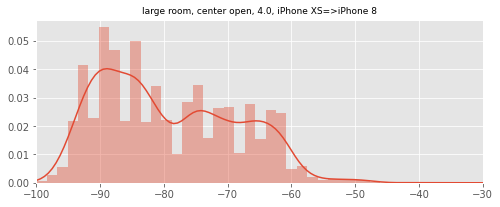

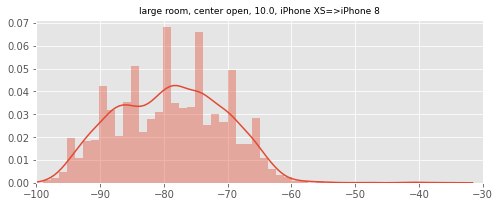

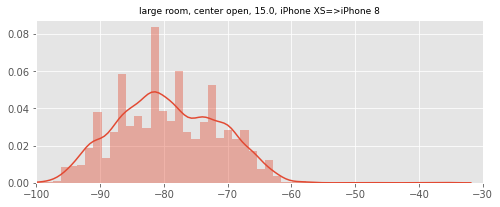

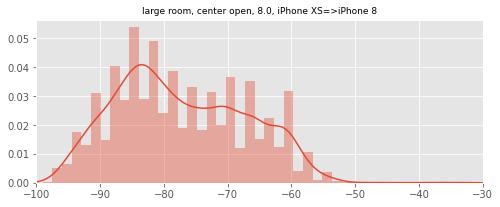

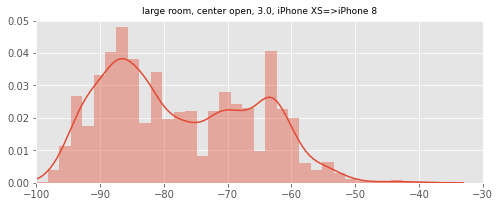

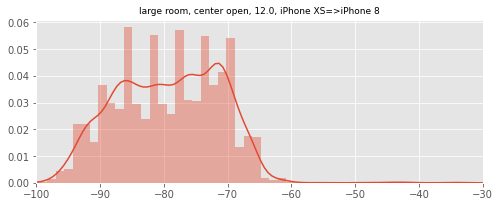

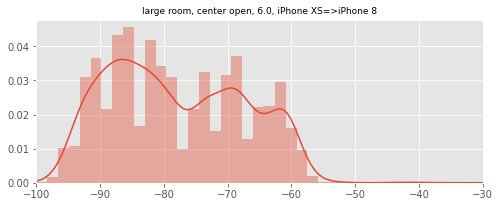

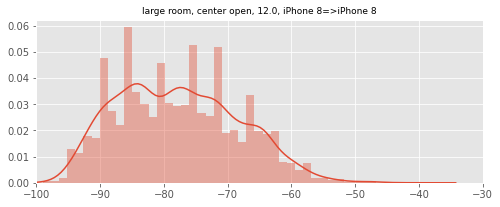

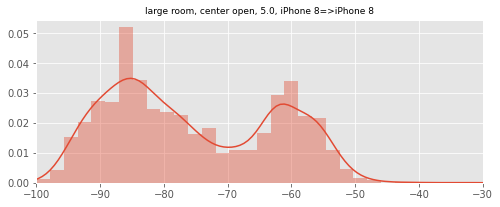

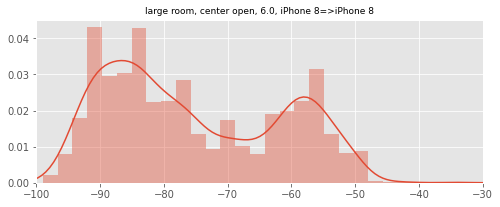

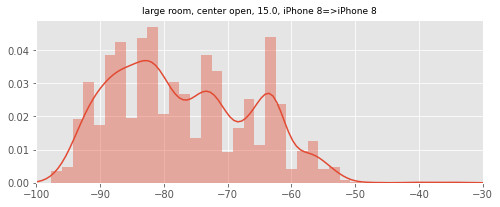

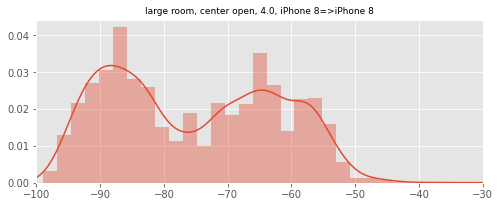

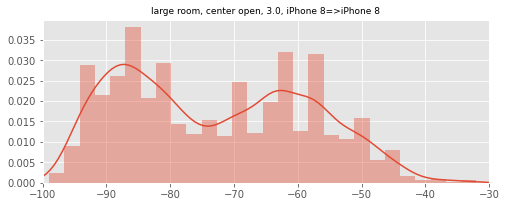

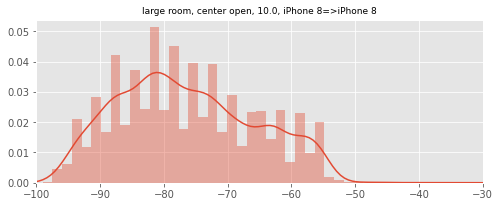

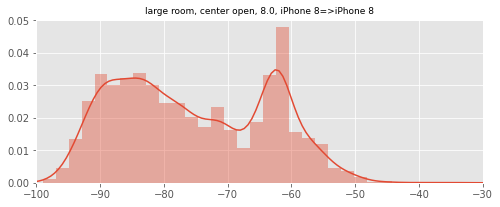

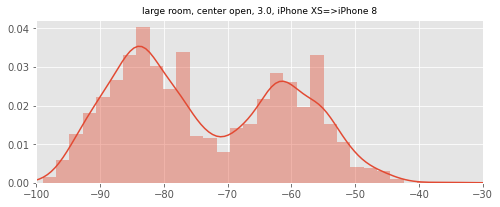

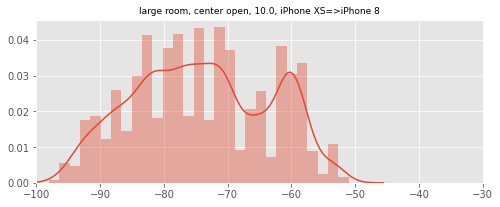

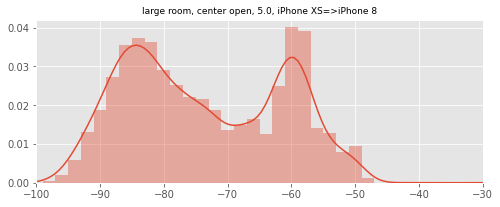

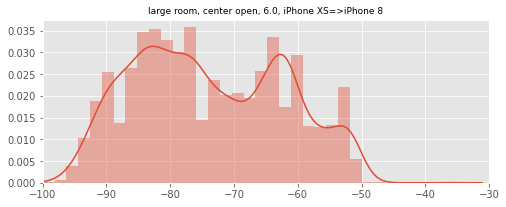

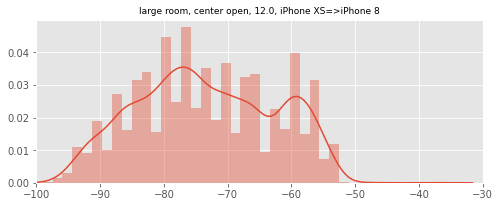

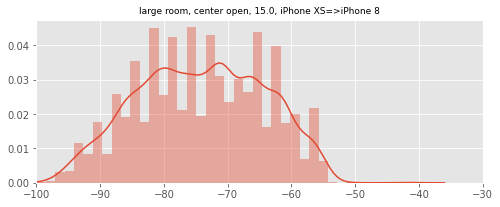

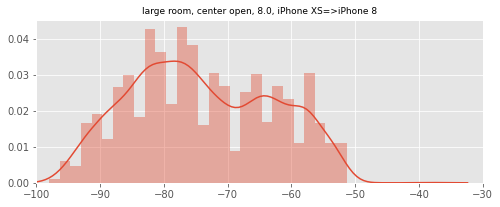

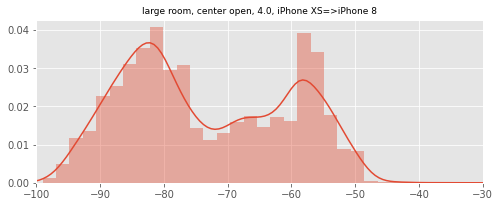

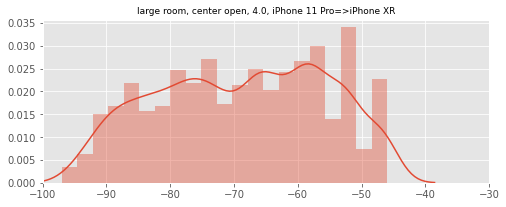

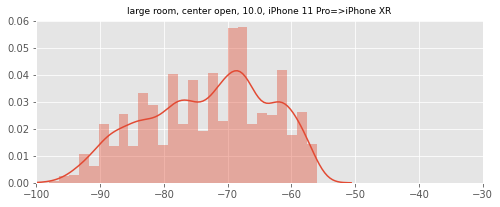

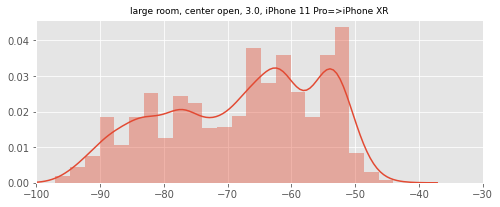

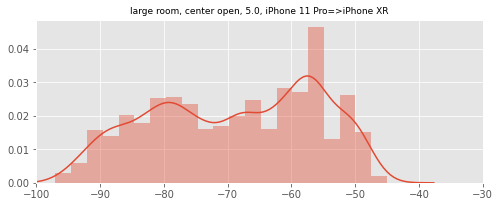

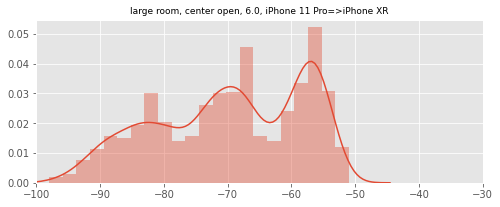

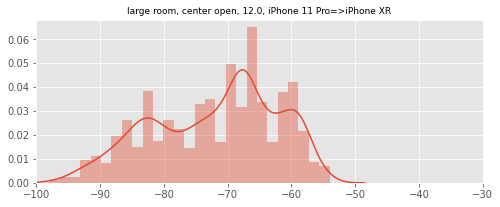

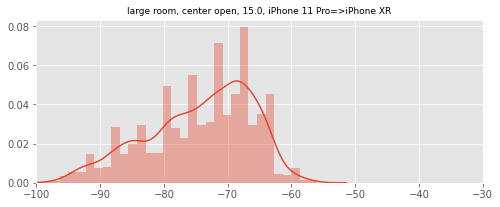

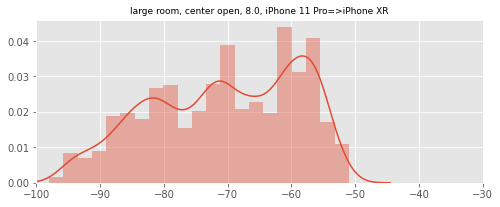

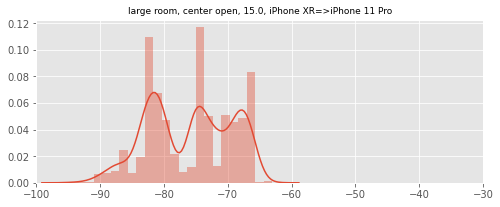

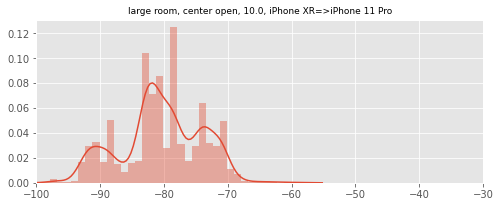

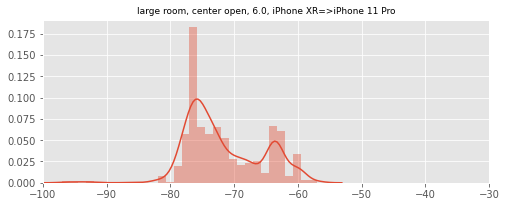

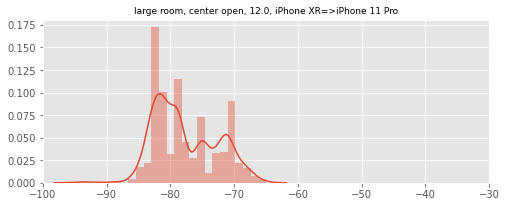

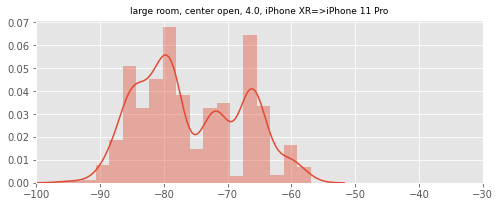

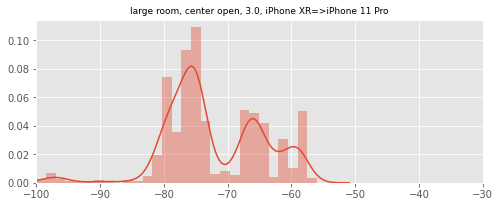

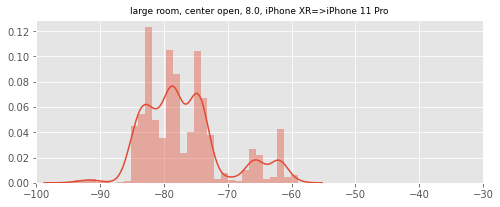

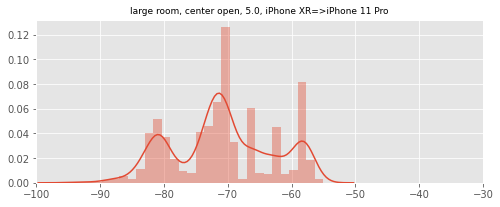

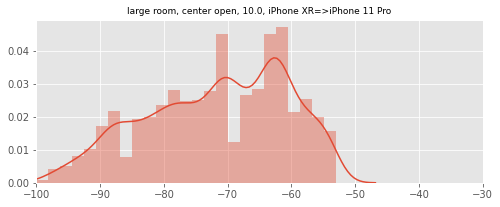

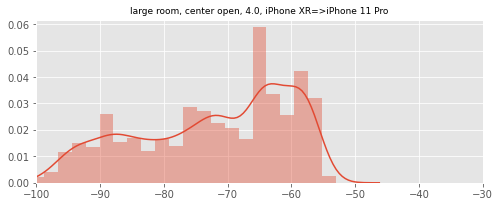

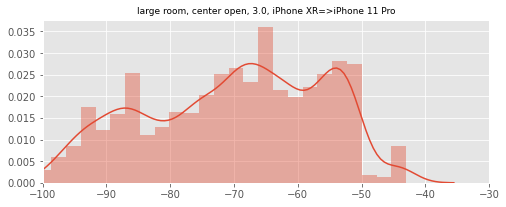

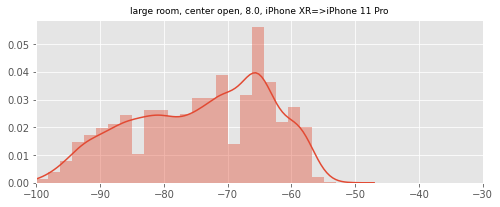

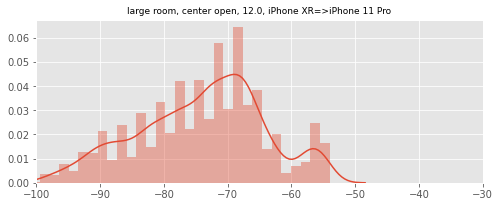

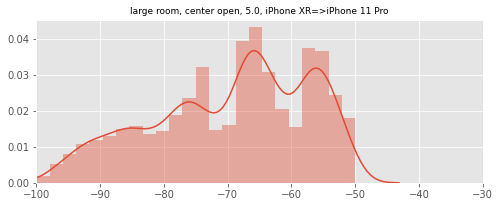

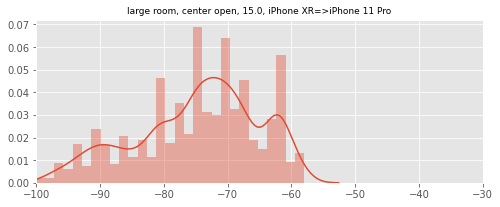

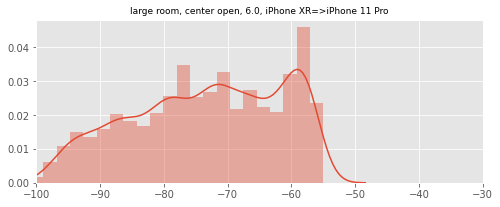

In [320]:
for idx, row in metadata[(metadata.Environment_1=='large room') & (metadata.Environment_2=='center open')].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

In [322]:
metadata.Environment_1.unique(), metadata.Environment_2.unique()

(array(['large room', 'hallway', 'medium room'], dtype=object),
 array(['center open', 'center congested'], dtype=object))

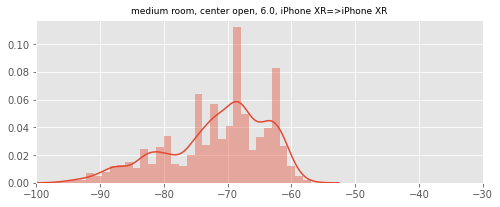

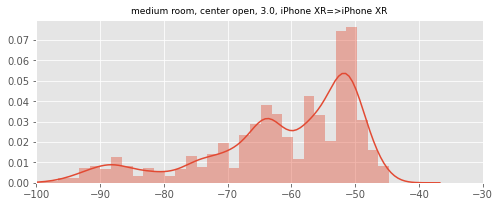

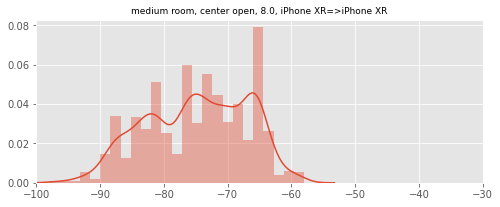

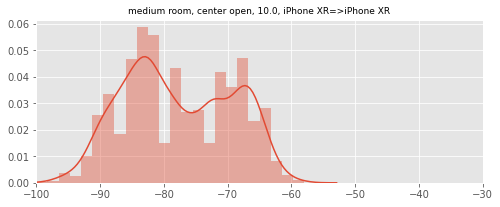

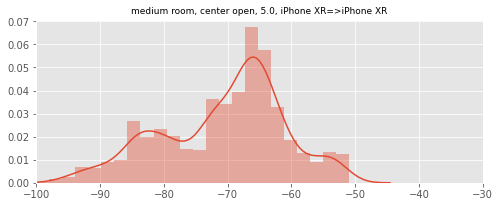

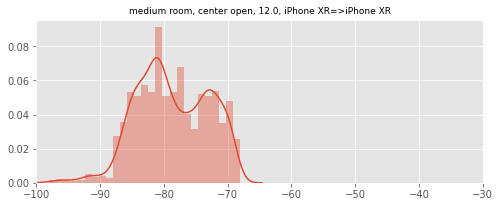

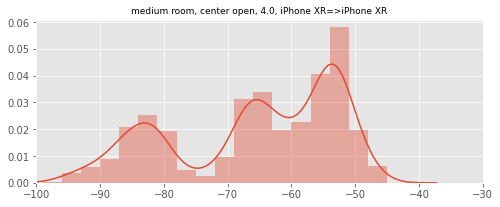

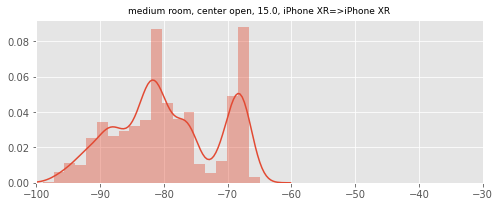

In [324]:
for idx, row in metadata[(metadata.Environment_1=='medium room') & (metadata.Environment_2=='center open')].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


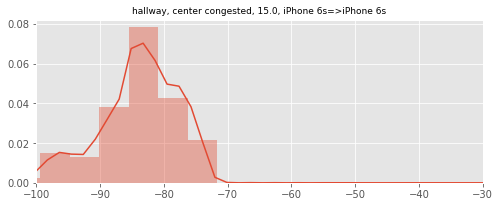

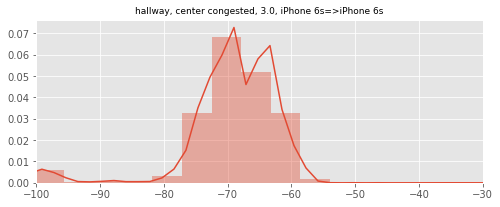

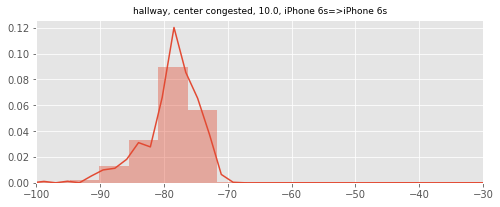

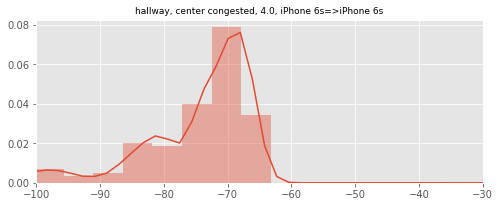

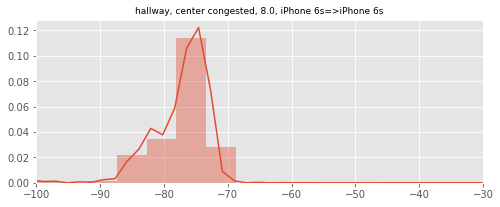

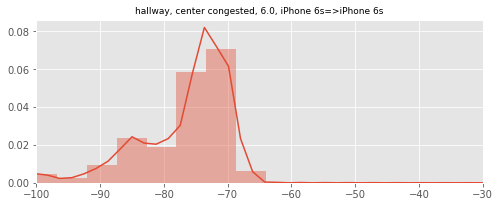

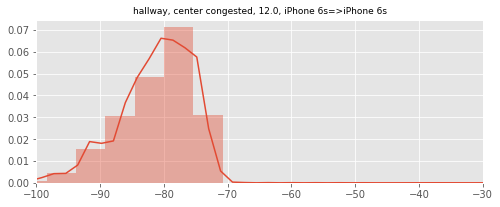

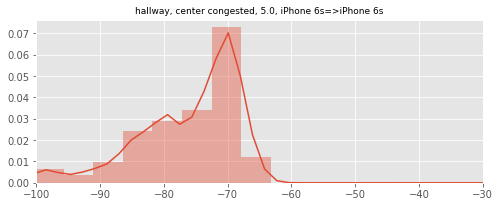

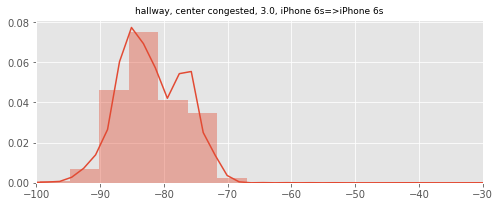

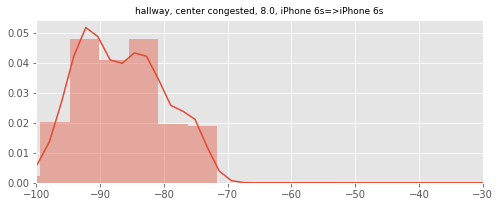

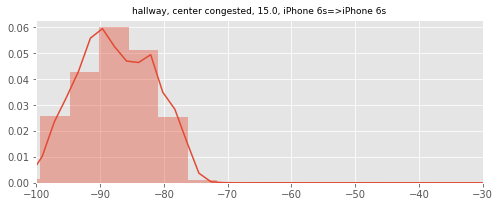

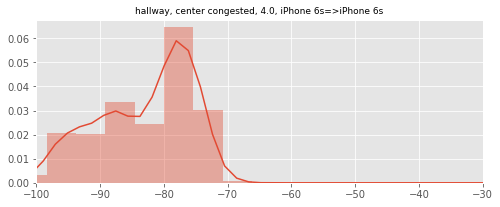

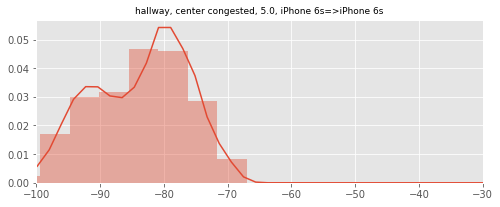

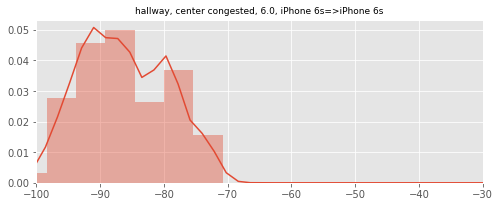

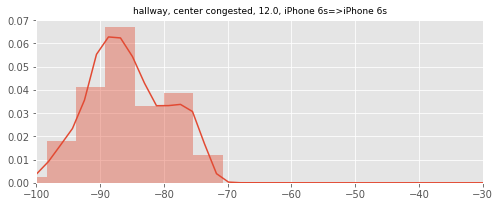

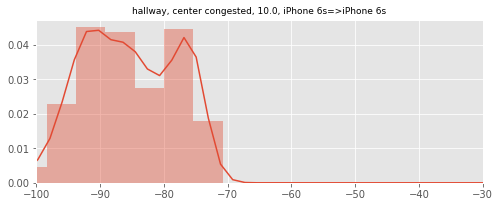

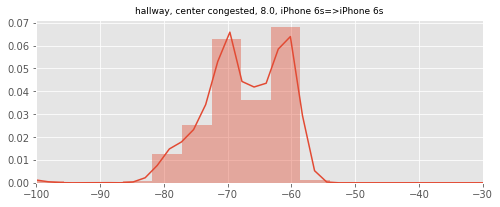

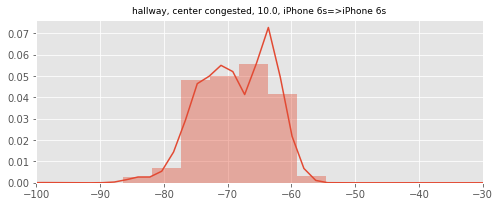

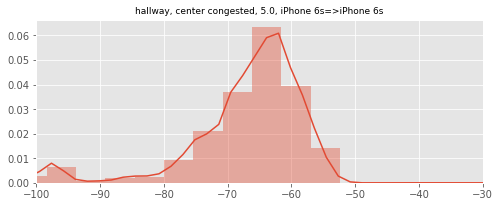

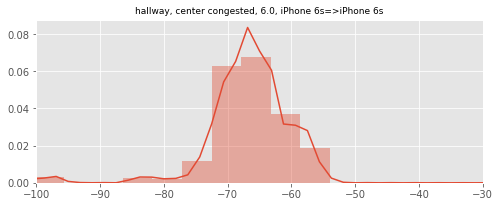

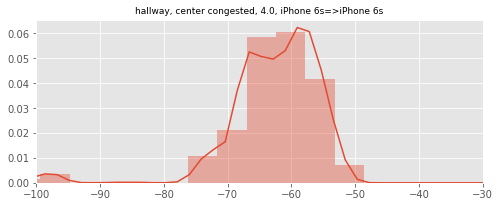

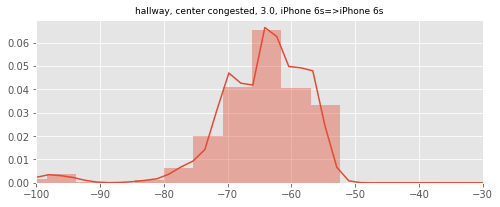

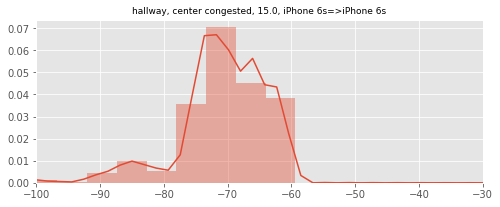

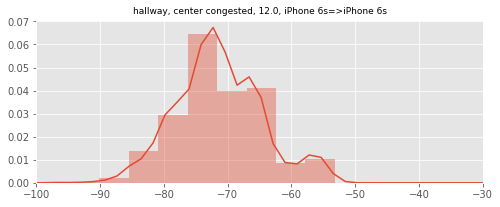

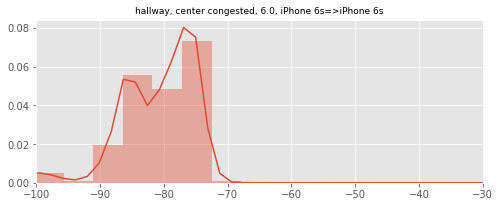

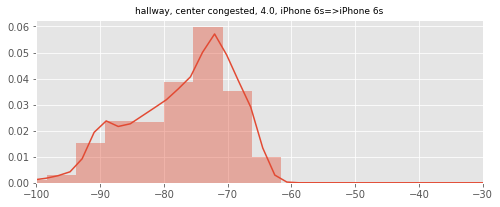

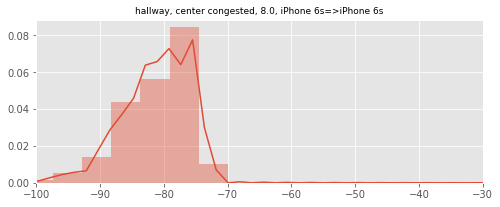

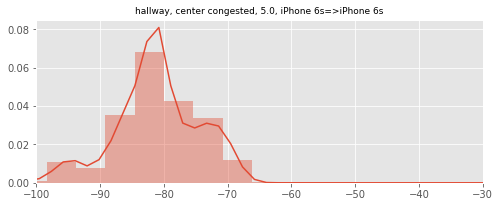

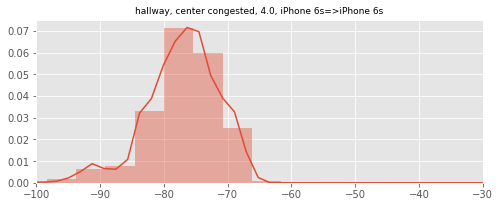

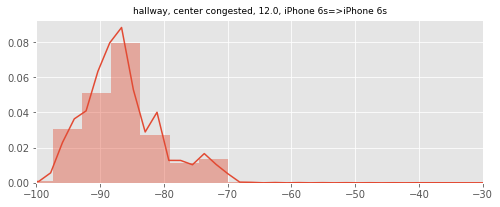

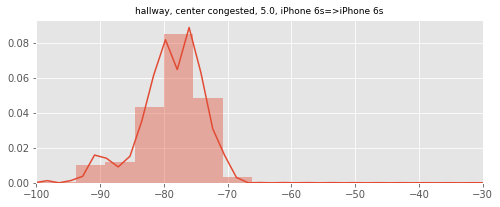

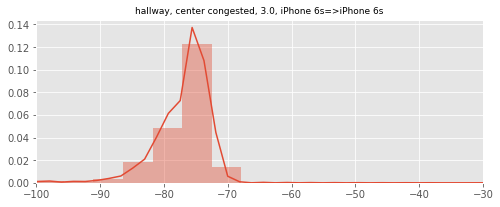

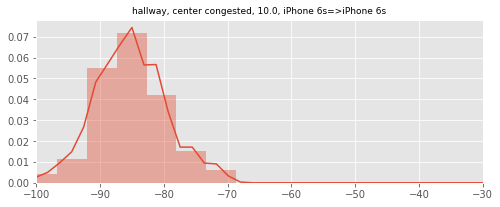

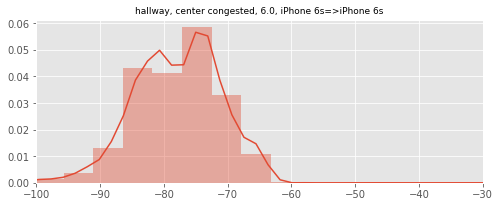

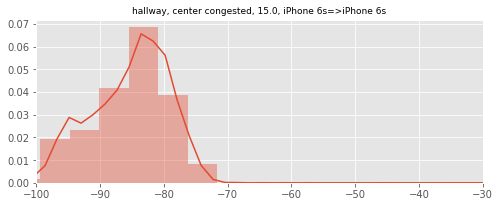

In [327]:
for idx, row in metadata[(metadata.Environment_1=='hallway') & (metadata.Environment_2=='center congested')].iterrows():
    plt.figure(figsize=(8, 3))
    sns.distplot(row.Bluetooth)
    title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
    plt.title(title, fontsize=9)
    plt.xlim(-100, -30)

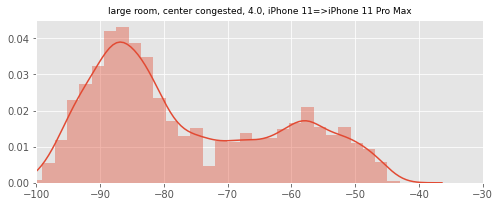

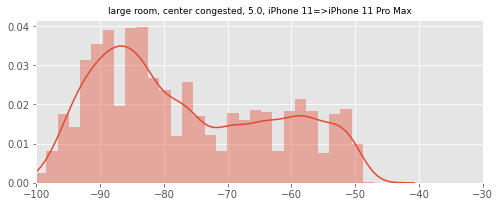

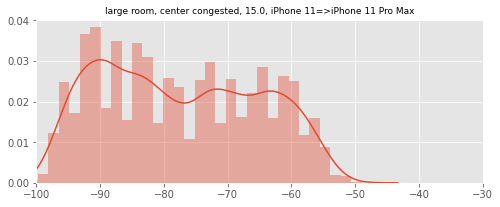

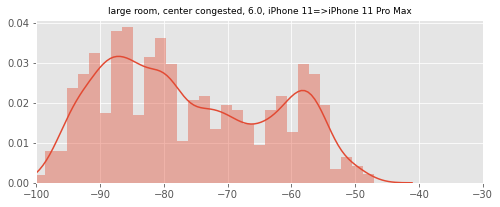

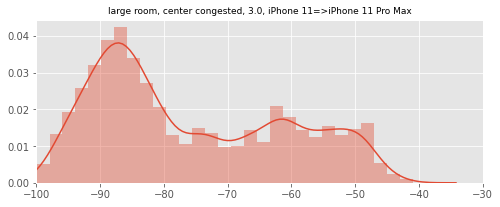

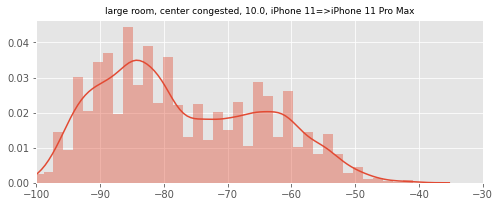

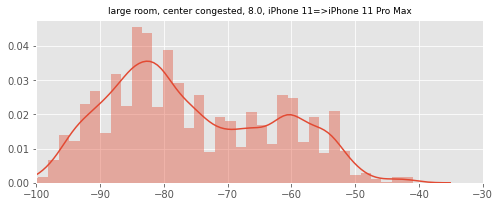

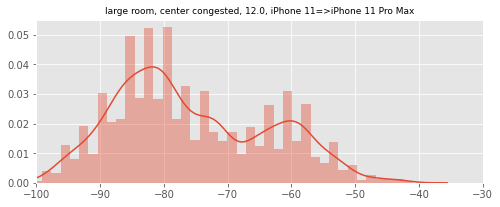

In [336]:
for idx, row in metadata[(metadata.Environment_1=='large room') & (metadata.Environment_2=='center congested')].iterrows():
    if not np.isnan(row.Range):
        plt.figure(figsize=(8, 3))
        sns.distplot(row.Bluetooth)
        title = f"{row.Environment_1}, {row.Environment_2}, {row.Range}, {row.TX}=>{row.RX}"
        plt.title(title, fontsize=9)
        plt.xlim(-100, -30)

<AxesSubplot:>

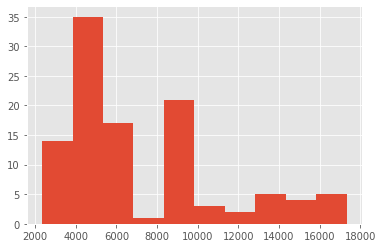

In [339]:
metadata.Bluetooth.apply(lambda x: len(x)).hist()

# Environment Prediction

In [376]:
def map_sequence_to_hist(seq):
    counts, bins = np.histogram(seq, bins=np.arange(-100, -30), density=True)
    return {
        f"Hist_{abs(_bin)}": count for _bin, count in zip(bins[1:], counts)
    }

In [397]:
X = pd.DataFrame(metadata.Bluetooth.apply(map_sequence_to_hist).values.tolist())
y = metadata.apply(lambda row: row.Environment_1 + ' | ' + row.Environment_2, axis=1).values

In [441]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = pd.DataFrame()
for col in X.columns:
    scalar = MinMaxScaler()
    X_scaled[col] = scalar.fit_transform(X[col].values.reshape(-1, 1)).reshape(-1)

In [457]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=1)

## Hyperparam Optimization

In [449]:
from src.hyperopt import optimize_hp, optimize

#estim, best_model = optimize_hp(X, y)
rf = RandomForestClassifier()
estim = optimize(rf, X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.7min finished


In [458]:
(estim.predict(X_test) == y_test).mean()

0.8611111111111112

In [463]:
ypred = estim.predict(X_test)
acc = (ypred == y_test).mean()
acc

0.8611111111111112

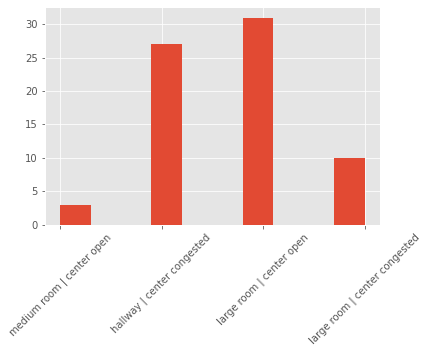

In [468]:
plt.hist(y_train)
plt.xticks(rotation=45);

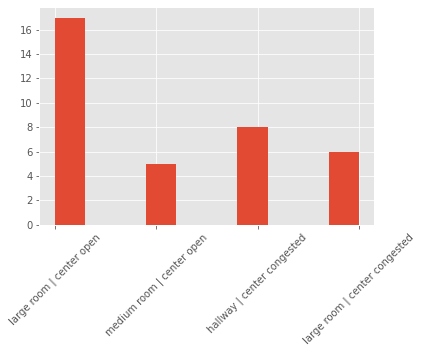

In [467]:
plt.hist(y_test)
plt.xticks(rotation=45);

In [464]:
y_test[ypred != y_test]

array(['medium room | center open', 'medium room | center open',
       'medium room | center open', 'medium room | center open',
       'medium room | center open'], dtype=object)

In [469]:
failed_cases = X_test[ypred != y_test]

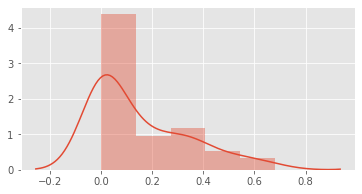

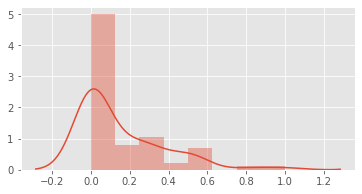

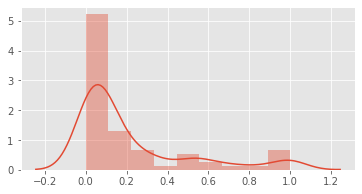

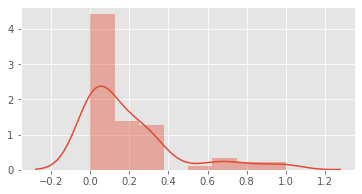

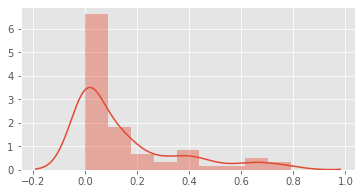

In [475]:
for idx, row in failed_cases.iterrows():
    plt.figure(figsize=(6, 3))
    sns.distplot(row.to_numpy())

## Hyperopt on the Whole set

In [481]:
from src.hyperopt import optimize_hp, optimize

#estim, best_model = optimize_hp(X, y)
rf = RandomForestClassifier()
estim = optimize(rf, X_scaled, y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.8min finished


In [487]:
y_tr_pred = estim.predict(X_train)
print(y_train[y_tr_pred != y_train])

['medium room | center open' 'medium room | center open'
 'medium room | center open']


In [483]:
ypred = estim.predict(X_test)
acc = (ypred == y_test).mean()
acc

0.8611111111111112

In [484]:
y_test[ypred != y_test]

array(['medium room | center open', 'medium room | center open',
       'medium room | center open', 'medium room | center open',
       'medium room | center open'], dtype=object)

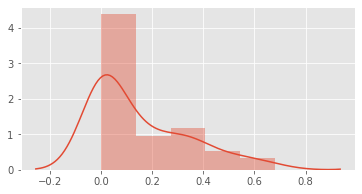

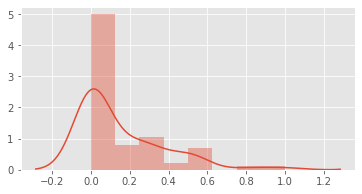

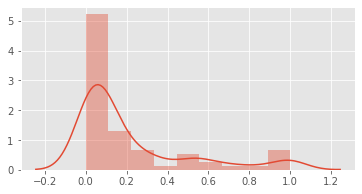

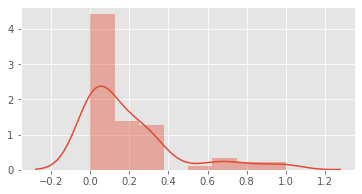

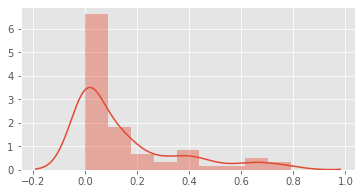

In [485]:
failed_cases = X_test[ypred != y_test]

for idx, row in failed_cases.iterrows():
    plt.figure(figsize=(6, 3))
    sns.distplot(row.to_numpy())

In [492]:
metadata

Environment_1 Environment_2         TX             RX  Range  Angle  \
0      large room   center open  iPhone XS       iPhone 8    5.0    0.0   
1      large room   center open  iPhone XS       iPhone 8    4.0    0.0   
2      large room   center open  iPhone XS       iPhone 8   10.0    0.0   
3      large room   center open  iPhone XS       iPhone 8   15.0    0.0   
4      large room   center open  iPhone XS       iPhone 8    8.0    0.0   
..            ...           ...        ...            ...    ...    ...   
102    large room   center open  iPhone XR  iPhone 11 Pro    8.0    0.0   
103    large room   center open  iPhone XR  iPhone 11 Pro   12.0    0.0   
104    large room   center open  iPhone XR  iPhone 11 Pro    5.0    0.0   
105    large room   center open  iPhone XR  iPhone 11 Pro   15.0    0.0   
106    large room   center open  iPhone XR  iPhone 11 Pro    6.0    0.0   

                                             Bluetooth  
0    [-84.0, -84.0, -71.0, -61.0, -83.0, -82.0, -82...  
1    [-59.0, -75.0, -75.0, -55.0, -55.0, -92.0, -75...  
2    [-82.0, -77.0, -78.0, -85.0, -85.0, -72.0, -75...  
3    [-71.0, -74.0, -69.0, -69.0, -64.0, -64.0, -76...  
4    [-79.0, -79.0, -73.0, -84.0, -74.0, -56.0, -56...  
..                                                 ...  
102  [-55.0, -55.0, -79.0, -75.0, -73.0, -57.0, -57...  
103  [-76.0, -83.0, -63.0, -63.0, -71.0, -71.0, -91...  
104  [-72.0, -83.0, -54.0, -54.0, -55.0, -55.0, -75...  
105  [-71.0, -71.0, -93.0, -93.0, -68.0, -82.0, -62...  
106  [-67.0, -59.0, -59.0, -84.0, -57.0, -58.0, -74...  

[107 rows x 7 columns]

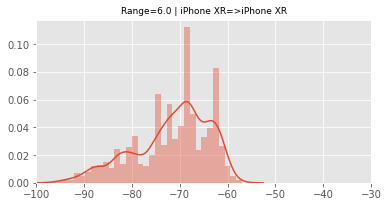

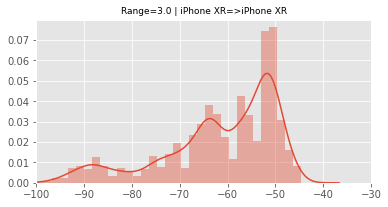

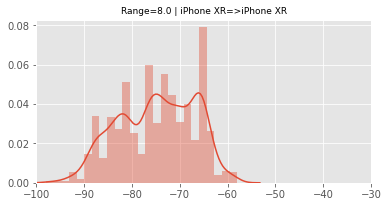

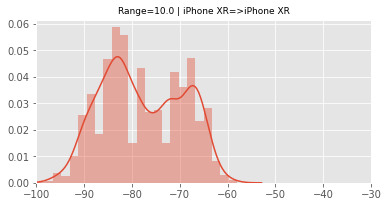

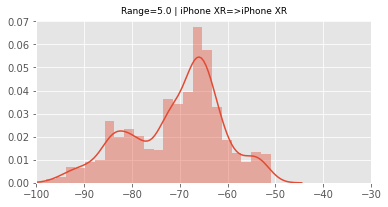

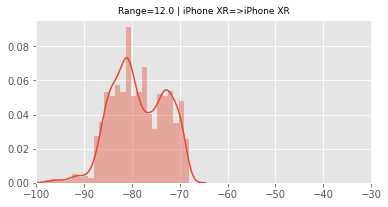

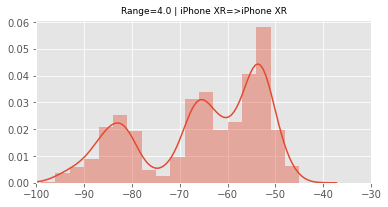

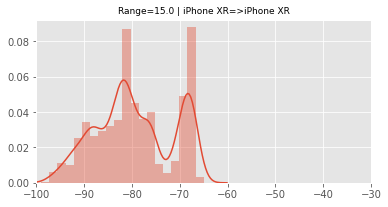

In [498]:
for idx, row in metadata[(metadata.Environment_1 == 'medium room') & (metadata.Environment_2 == 'center open')].iterrows():
    plt.figure(figsize=(6, 3))
    sns.distplot(row.Bluetooth)
    plt.title(f"Range={row.Range} | {row.TX}=>{row.RX}", fontsize=9)
    plt.xlim(-100, -30)

In [499]:
metadata[metadata.RX == 'iPhone XR']

Environment_1 Environment_2             TX         RX  Range  Angle  \
32   medium room   center open      iPhone XR  iPhone XR    6.0    0.0   
33   medium room   center open      iPhone XR  iPhone XR    3.0    0.0   
34   medium room   center open      iPhone XR  iPhone XR    8.0    0.0   
35   medium room   center open      iPhone XR  iPhone XR   10.0    0.0   
36   medium room   center open      iPhone XR  iPhone XR    5.0    0.0   
37   medium room   center open      iPhone XR  iPhone XR   12.0    0.0   
38   medium room   center open      iPhone XR  iPhone XR    4.0    0.0   
39   medium room   center open      iPhone XR  iPhone XR   15.0    0.0   
83    large room   center open  iPhone 11 Pro  iPhone XR    4.0    0.0   
84    large room   center open  iPhone 11 Pro  iPhone XR   10.0    0.0   
85    large room   center open  iPhone 11 Pro  iPhone XR    3.0    0.0   
86    large room   center open  iPhone 11 Pro  iPhone XR    5.0    0.0   
87    large room   center open  iPhone 11 Pro  iPhone XR    6.0    0.0   
88    large room   center open  iPhone 11 Pro  iPhone XR   12.0    0.0   
89    large room   center open  iPhone 11 Pro  iPhone XR   15.0    0.0   
90    large room   center open  iPhone 11 Pro  iPhone XR    8.0    0.0   

                                            Bluetooth  
32  [-62.0, -62.0, -70.0, -70.0, -86.0, -71.0, -70...  
33  [-79.0, -60.0, -61.0, -62.0, -62.0, -79.0, -59...  
34  [-64.0, -63.0, -61.0, -61.0, -65.0, -64.0, -88...  
35  [-66.0, -66.0, -61.0, -63.0, -62.0, -62.0, -64...  
36  [-59.0, -60.0, -85.0, -59.0, -59.0, -54.0, -54...  
37  [-77.0, -77.0, -81.0, -81.0, -82.0, -76.0, -77...  
38  [-59.0, -81.0, -50.0, -50.0, -57.0, -57.0, -55...  
39  [-66.0, -67.0, -70.0, -70.0, -71.0, -71.0, -83...  
83  [-64.0, -56.0, -57.0, -50.0, -50.0, -71.0, -87...  
84  [-64.0, -64.0, -76.0, -57.0, -57.0, -77.0, -59...  
85  [-77.0, -52.0, -52.0, -68.0, -55.0, -55.0, -78...  
86  [-51.0, -51.0, -73.0, -63.0, -51.0, -51.0, -72...  
87  [-84.0, -56.0, -56.0, -65.0, -74.0, -67.0, -67...  
88  [-61.0, -61.0, -64.0, -86.0, -86.0, -85.0, -61...  
89  [-67.0, -68.0, -82.0, -83.0, -78.0, -67.0, -67...  
90  [-62.0, -62.0, -69.0, -68.0, -80.0, -69.0, -61...

# Device Prediction

In [502]:
metadata = metadata.dropna()

In [503]:
metadata.apply(lambda row: f"{row.TX} => {row.RX}", axis=1).values

array(['iPhone XS => iPhone 8', 'iPhone XS => iPhone 8',
       'iPhone XS => iPhone 8', 'iPhone XS => iPhone 8',
       'iPhone XS => iPhone 8', 'iPhone XS => iPhone 8',
       'iPhone XS => iPhone 8', 'iPhone XS => iPhone 8',
       'iPhone 8 => iPhone 8', 'iPhone 8 => iPhone 8',
       'iPhone 8 => iPhone 8', 'iPhone 8 => iPhone 8',
       'iPhone 8 => iPhone 8', 'iPhone 8 => iPhone 8',
       'iPhone 8 => iPhone 8', 'iPhone 8 => iPhone 8',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone 6s => iPhone 6s', 'iPhone 6s => iPhone 6s',
       'iPhone XR => iPhone XR', 'iPhone XR => iPhone XR',
       'iPhone XR => 

In [504]:
X = pd.DataFrame(metadata.Bluetooth.apply(map_sequence_to_hist).values.tolist())
y = metadata.apply(lambda row: f"{row.TX} => {row.RX}", axis=1).values

In [507]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = pd.DataFrame()
for col in X.columns:
    scalar = MinMaxScaler()
    X_scaled[col] = scalar.fit_transform(X[col].values.reshape(-1, 1)).reshape(-1)

In [509]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=1)

In [510]:
from src.hyperopt import optimize

forest = RandomForestClassifier()
estim = optimize(forest, X_scaled, y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.7min finished


In [ ]:
ypred = estim.predict(X_test)
accuracy = (ypred == y_test).mean()
accuracy

In [513]:
from src.hyperopt import optimize

forest = RandomForestClassifier()
estim_train = optimize(forest, X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 692 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.6min finished


In [514]:
ypred_ = estim.predict(X_test)
accuracy_ = (ypred_ == y_test).mean()
accuracy_

1.0

In [516]:
metadata.to_csv('data/processed/MIT-Matrix-Data.Bluetooth.csv', index=False)

# Predict Distance

In [522]:
y = metadata.Range.values
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=1)

In [525]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

In [528]:
(abs(y_test - ypred)).mean()

3.0203030303030305

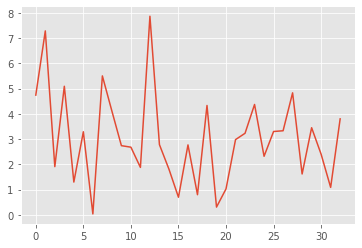

In [529]:
plt.plot((abs(y_test - ypred)))

In [526]:
ypred = regr.predict(X_test)
mean_squared_error(y_test, ypred)

12.406445454545455

In [530]:
from src.hyperopt import optimize

forest = RandomForestRegressor()
estim = optimize(forest, X_scaled, y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.5min finished


In [531]:
ypred = estim.predict(X_test)
(abs(y_test - ypred)).mean()

1.7946040995936863

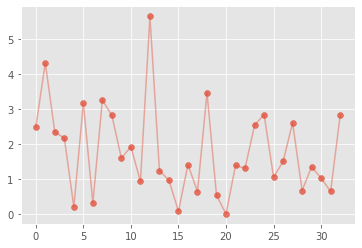

In [542]:
plt.scatter(np.arange(y_test.shape[0]), abs(y_test - ypred), alpha=0.75);
plt.plot(np.arange(y_test.shape[0]), abs(y_test - ypred), alpha=0.42);